In [1]:
!git clone https://github.com/muxspace/facial_expressions.git

Cloning into 'facial_expressions'...
remote: Enumerating objects: 14214, done.
remote: Total 14214 (delta 0), reused 0 (delta 0), pack-reused 14214
Receiving objects: 100% (14214/14214), 239.65 MiB | 25.08 MiB/s, done.
Resolving deltas: 100% (223/223), done.
Checking out files: 100% (13996/13996), done.


In [0]:
!mkdir data

## Categorize images into subfolders

In [0]:
import os
import csv
import shutil

from collections import defaultdict

In [0]:
images = defaultdict(list)

with open('facial_expressions/data/legend.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)
    for _, image_filename, emotion_category in csv_reader:
        images[emotion_category.lower()].append(image_filename)

In [5]:
images.keys()

dict_keys(['anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness', 'sadness', 'contempt'])

In [9]:
total_images = 0

for emotion_category, image_files in images.items():
    print(emotion_category, len(image_files))
    total_images += len(image_files)

print(total_images)

anger 252
surprise 368
disgust 208
fear 21
neutral 6868
happiness 5696
sadness 268
contempt 9
13690


In [0]:
data_basedir = 'data'
image_source_basedir = 'facial_expressions/images'

for emotion_category, image_files in images.items():
    emotion_category_dir = os.path.join(data_basedir, emotion_category)
    os.makedirs(emotion_category_dir)
    
    for image_file in image_files:
        source = os.path.join(image_source_basedir, image_file)
        destination = os.path.join(emotion_category_dir, image_file)
        shutil.copyfile(source, destination)

In [0]:
# Remove images categorized as contempt due to lack of data (only 9 images)
!rm -rf data/contempt

##Train emotion classifier

The model architecture is inspired from flower-recognizer

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
data_basedir = 'data'

IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_basedir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data_basedir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 10943 images belonging to 7 classes.
Found 2731 images belonging to 7 classes.


In [0]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 7))

Save labels file

In [0]:
print (train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)

{'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}


In [0]:
!cat labels.txt

anger
disgust
fear
happiness
neutral
sadness
surprise

### Create base model using MobileNet

In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [0]:
base_model.trainable = False

Create emotion classification model on top base_model

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(7, activation='softmax')
])

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 231       
Total params: 2,626,887
Trainable params: 368,903
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [0]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
171/171 [==============================] - 37s 216ms/step - loss: 0.8480 - accuracy: 0.7127 - val_loss: 0.6930 - val_accuracy: 0.7525
Epoch 2/10
171/171 [==============================] - 34s 201ms/step - loss: 0.6147 - accuracy: 0.7807 - val_loss: 0.6909 - val_accuracy: 0.7473
Epoch 3/10
171/171 [==============================] - 34s 201ms/step - loss: 0.5521 - accuracy: 0.8017 - val_loss: 0.5917 - val_accuracy: 0.8001
Epoch 4/10
171/171 [==============================] - 34s 200ms/step - loss: 0.5006 - accuracy: 0.8171 - val_loss: 0.5901 - val_accuracy: 0.7891
Epoch 5/10
171/171 [==============================] - 34s 201ms/step - loss: 0.4688 - accuracy: 0.8264 - val_loss: 0.6228 - val_accuracy: 0.7744
Epoch 6/10
171/171 [==============================] - 34s 201ms/step - loss: 0.4471 - accuracy: 0.8314 - val_loss: 0.6325 - val_accuracy: 0.7895
Epoch 7/10
171/171 [==============================] - 34s 200ms/step - loss: 0.4241 - accuracy: 0.8425 - val_loss: 0.5927 - val_ac

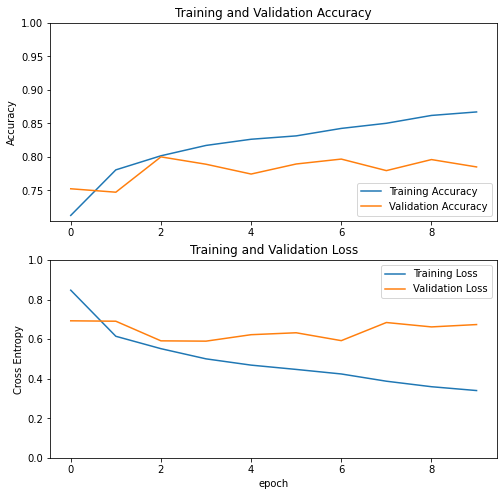

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning

In [0]:
base_model.trainable = True

In [0]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 231       
Total params: 2,626,887
Trainable params: 2,231,495
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


In [0]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=10, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/10
171/171 [==============================] - 45s 264ms/step - loss: 0.3365 - accuracy: 0.8696 - val_loss: 0.9323 - val_accuracy: 0.7931
Epoch 2/10
171/171 [==============================] - 45s 262ms/step - loss: 0.2874 - accuracy: 0.8906 - val_loss: 0.9220 - val_accuracy: 0.7854
Epoch 3/10
171/171 [==============================] - 45s 262ms/step - loss: 0.2495 - accuracy: 0.9015 - val_loss: 0.8639 - val_accuracy: 0.8048
Epoch 4/10
171/171 [==============================] - 45s 262ms/step - loss: 0.2185 - accuracy: 0.9138 - val_loss: 0.8275 - val_accuracy: 0.8129
Epoch 5/10
171/171 [==============================] - 45s 263ms/step - loss: 0.1837 - accuracy: 0.9321 - val_loss: 0.8418 - val_accuracy: 0.8140
Epoch 6/10
171/171 [==============================] - 45s 261ms/step - loss: 0.1597 - accuracy: 0.9409 - val_loss: 0.8213 - val_accuracy: 0.8198
Epoch 7/10
171/171 [==============================] - 45s 261ms/step - loss: 0.1450 - accuracy: 0.9467 - val_loss: 0.8915 - val_ac

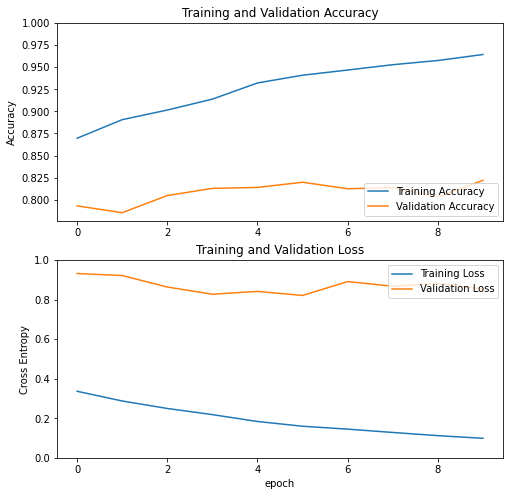

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Convert to TFLite

In [0]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets
